# Using YOLOv5 for bounding box detection

In [59]:
import yolov5
import os
import random
from PIL import Image

In [60]:
# load model
model = yolov5.load('keremberke/yolov5m-license-plate')

YOLOv5  2023-11-26 Python-3.10.10 torch-2.1.1+cpu CPU

Fusing layers... 
Model summary: 212 layers, 20852934 parameters, 0 gradients, 47.9 GFLOPs
Adding AutoShape... 


In [61]:
# set model parameters
model.conf = 0.25  # NMS confidence threshold
model.iou = 0.45  # NMS IoU threshold
model.agnostic = False  # NMS class-agnostic
model.multi_label = False  # NMS multiple labels per box
model.max_det = 1  # maximum number of detections per image

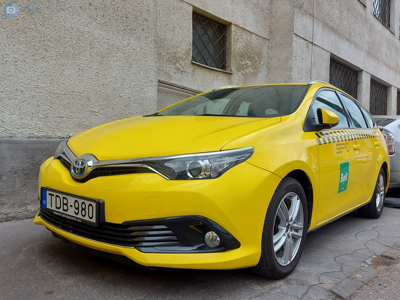

In [62]:
# set image
files = os.listdir("./data/images_new/")
img = Image.open("./data/images_new/" + random.choice(files))
#show image in notebook
img.resize((400, 300))

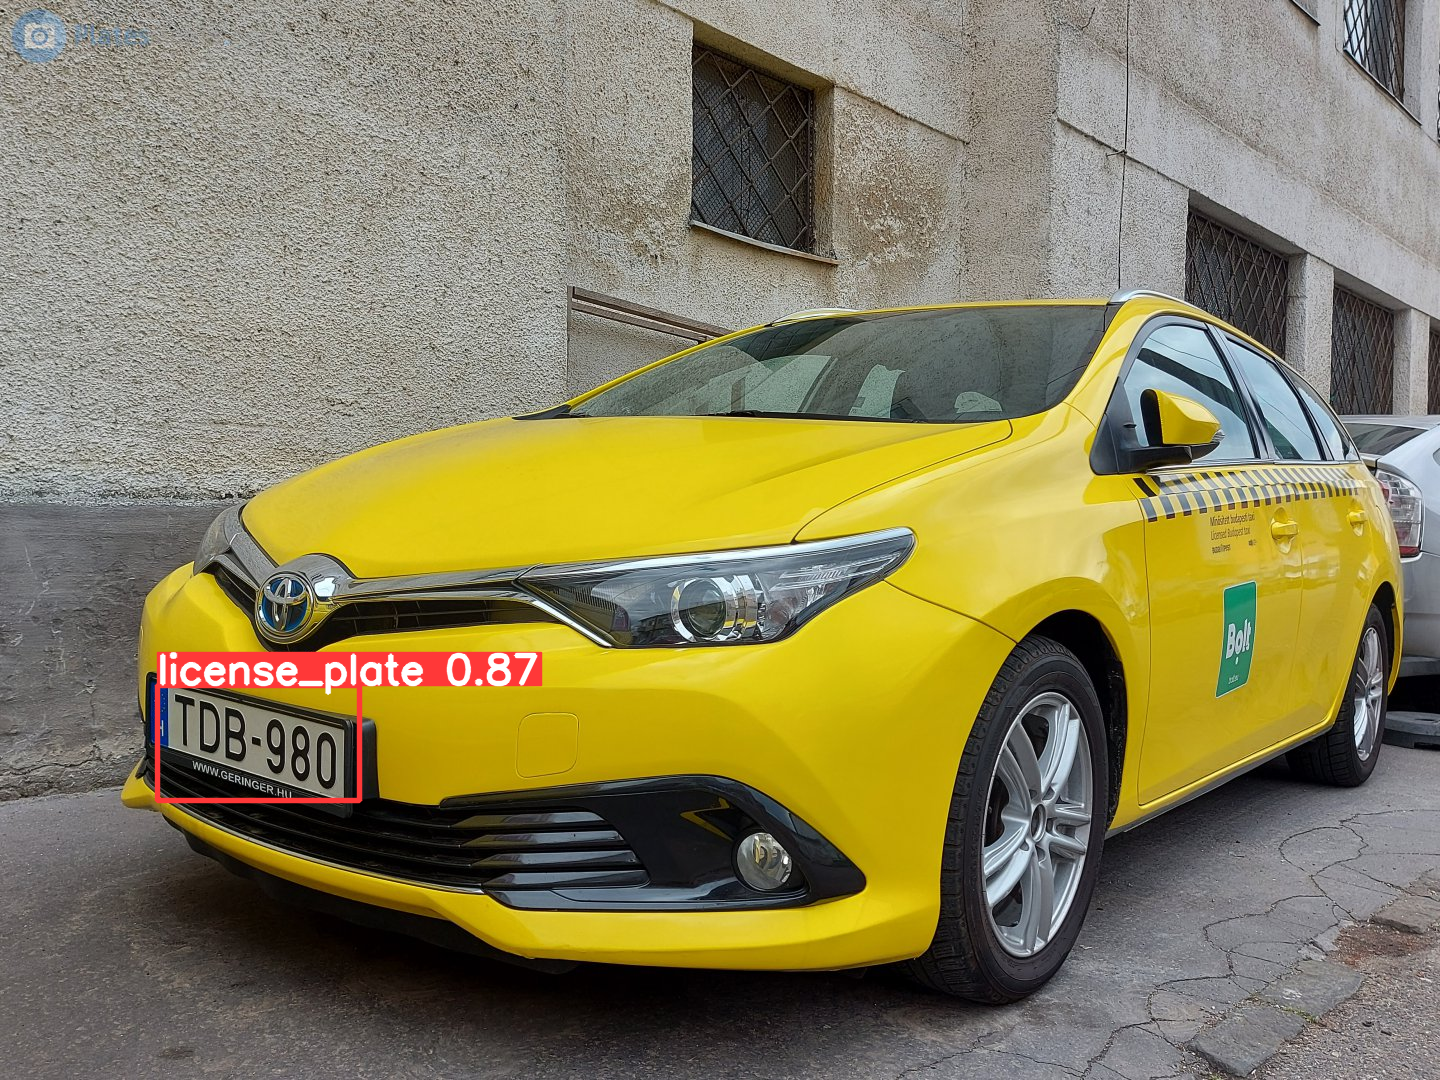

In [74]:
# perform inference
results = model(img, size=640)

# inference with test time augmentation
results = model(img, augment=True)

# parse results
predictions = results.pred[0]
boxes = predictions[:, :4] # x1, y1, x2, y2
scores = predictions[:, 4]
categories = predictions[:, 5]

# show detection bounding boxes on image
results.show()

# save results into "results/" folder
#results.save(save_dir='./results/result')

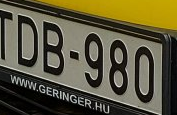

In [75]:
# crop detected license plates
boxes = boxes.numpy()
cropped = img.crop((boxes[0][0], boxes[0][1], boxes[0][2], boxes[0][3]))
#crop left 12%
cropped = cropped.crop((cropped.width * 0.12, 0, cropped.width, cropped.height))
cropped

# Perform OCR on cropped plate

In [65]:
from transformers import TrOCRProcessor, VisionEncoderDecoderModel
import requests
from PIL import Image

In [66]:
processor = TrOCRProcessor.from_pretrained("microsoft/trocr-base-printed")
ocr_model = VisionEncoderDecoderModel.from_pretrained("microsoft/trocr-base-printed")

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.
Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-printed and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [76]:
pixel_values = processor(cropped, return_tensors="pt").pixel_values
generated_ids = ocr_model.generate(pixel_values)

generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]

In [77]:
generated_text

'TDB-980'

## Putting the two parts together

Valid license plate
expected: SCN-725
detected: SCN-725


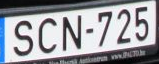

In [151]:
#load random image from test set
files = os.listdir("./data/images_new/")
choice = random.choice(files)
img = Image.open("./data/images_new/" + choice)

# inference with test time augmentation
results = model(img, size=640)

# parse results
predictions = results.pred[0]
boxes = predictions[:, :4] # x1, y1, x2, y2

# crop detected license plates
boxes = boxes.numpy()
cropped = img.crop((boxes[0][0], boxes[0][1], boxes[0][2], boxes[0][3]))
#crop left 11% of image
cropped = cropped.crop((cropped.width * 0.11, 0, cropped.width, cropped.height))

# perform OCR
pixel_values = processor(cropped, return_tensors="pt").pixel_values
generated_ids = ocr_model.generate(pixel_values)
generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
#some filtering for misdetected characters
generated_text = generated_text.replace(".", " ").replace("*", " ").replace("@", " ").replace(":", "-").replace("]", "").replace("[", "").replace(")", "").replace("(", "").replace(";", "").replace("!", "1").replace("?", "7").replace("§", "5").replace("€", "6").replace("=", "0").replace("ß", "8").replace("ü", "4").replace("ö", "3").replace("ä", "2").replace("„", "").replace("“", "").replace("’", "").replace("‘", "").replace("´", "").replace("°", "").replace("¨", "")
#check if license plate is valid and fix if possible
if '-' in generated_text:
    parts = generated_text.split('-')
    chars = parts[0]
    numbers = parts[1]#

    if len(chars) == 3 and len(numbers) == 3:
        print("Valid license plate")
    elif ' ' in chars and len(chars) == 5 and len(numbers) == 3:
        print("Valid license plate")
    elif ' ' not in chars and len(chars) == 4 and len(numbers) == 3: #fix case when OCR detects country sign as part of license plate
        generated_text = generated_text[1:]
        print("Attempted to fix license plate")
#check if license_plate is missing separator
elif len(generated_text) == 6 and generated_text[0].isalpha() and generated_text[1].isalpha() and generated_text[2].isalpha() and generated_text[3].isdigit() and generated_text[4].isdigit() and generated_text[5].isdigit():
    generated_text = generated_text[0:3] + '-' + generated_text[3:]
    print("Attempted to fix license plate")
else:
    print("Invalid license plate")
# show image and OCR result
print("expected: " + choice.split('.')[0])
print("detected: " + generated_text)
cropped

